# 1. Install Dependencies and Setup

In [46]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [47]:
#!pip list

In [48]:
import tensorflow as tf
import os

In [49]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [50]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [51]:
import cv2
import imghdr # verificar las extenciones de los archivos

In [52]:
data_dir = 'data' 

In [53]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [54]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [55]:
import numpy as np
from matplotlib import pyplot as plt

In [56]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [57]:
data_iterator = data.as_numpy_iterator()

In [58]:
batch = data_iterator.next()

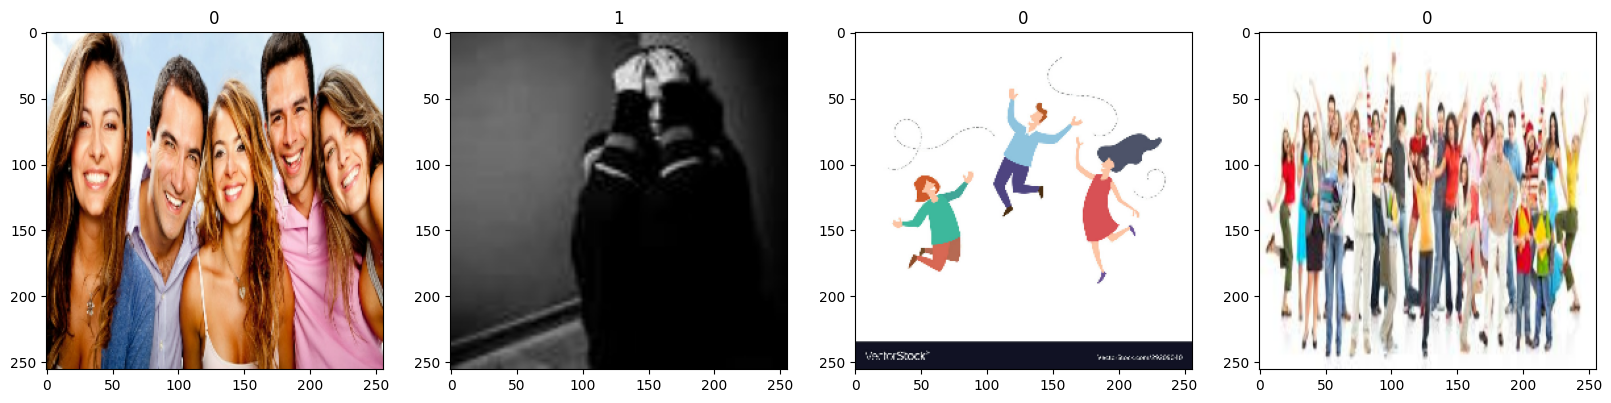

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [60]:
data = data.map(lambda x,y: (x/255, y))

In [61]:
data.as_numpy_iterator().next()

(array([[[[0.83170956, 0.84739584, 0.85916054],
          [0.8352941 , 0.8509804 , 0.8627451 ],
          [0.83697915, 0.8526654 , 0.8644301 ],
          ...,
          [0.9490196 , 0.9647059 , 0.96862745],
          [0.9490196 , 0.9647059 , 0.96862745],
          [0.9490196 , 0.9647059 , 0.96862745]],
 
         [[0.83344585, 0.8491321 , 0.8608968 ],
          [0.8352941 , 0.8509804 , 0.8627451 ],
          [0.83697915, 0.8526654 , 0.8644301 ],
          ...,
          [0.9471201 , 0.96280634, 0.9667279 ],
          [0.9471201 , 0.96280634, 0.9667279 ],
          [0.9471201 , 0.96280634, 0.9667279 ]],
 
         [[0.8352941 , 0.8509804 , 0.8627451 ],
          [0.8354363 , 0.85112256, 0.86288726],
          [0.8375306 , 0.8532169 , 0.8649816 ],
          ...,
          [0.94509804, 0.9607843 , 0.9647059 ],
          [0.94509804, 0.9607843 , 0.9647059 ],
          [0.94509804, 0.9607843 , 0.9647059 ]],
 
         ...,
 
         [[0.15722513, 0.20985994, 0.27205357],
          [0.16705

# 5. Split Data

In [62]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [103]:
train_size


7

In [104]:
val_size


2

In [105]:
test_size

1

In [64]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [65]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [67]:
model = Sequential()

In [68]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [69]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [71]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [73]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 3s 244ms/step - loss: 0.7659 - accuracy: 0.5268 - val_loss: 0.5776 - val_accuracy: 0.6875
Epoch 2/20
7/7 [==============================] - 3s 331ms/step - loss: 0.5762 - accuracy: 0.7143 - val_loss: 0.4614 - val_accuracy: 0.8125
Epoch 3/20
7/7 [==============================] - 3s 270ms/step - loss: 0.5418 - accuracy: 0.7455 - val_loss: 0.4411 - val_accuracy: 0.8750
Epoch 4/20
7/7 [==============================] - 3s 269ms/step - loss: 0.4265 - accuracy: 0.8304 - val_loss: 0.5029 - val_accuracy: 0.7344
Epoch 5/20
7/7 [==============================] - 3s 256ms/step - loss: 0.3950 - accuracy: 0.8080 - val_loss: 0.2534 - val_accuracy: 0.9062
Epoch 6/20
7/7 [==============================] - 3s 277ms/step - loss: 0.2251 - accuracy: 0.9286 - val_loss: 0.1649 - val_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 3s 299ms/step - loss: 0.1863 - accuracy: 0.9152 - val_loss: 0.1230 - val_accuracy: 0.9531
Epoch 8/20
7/7 [====

# 8. Plot Performance

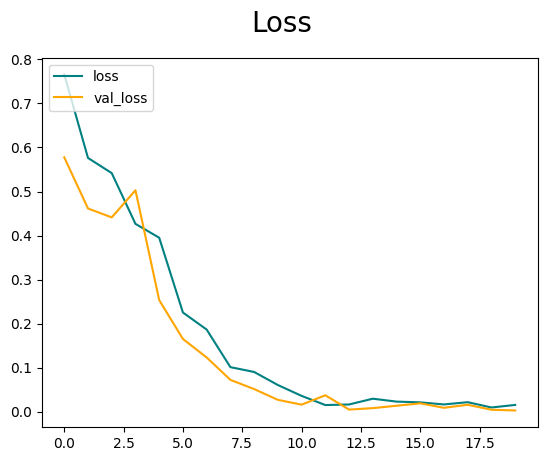

In [74]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

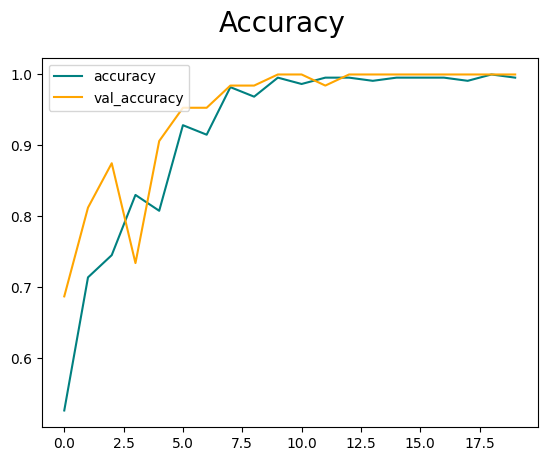

In [75]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [76]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [77]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [78]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 55ms/step


In [79]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [80]:
import cv2

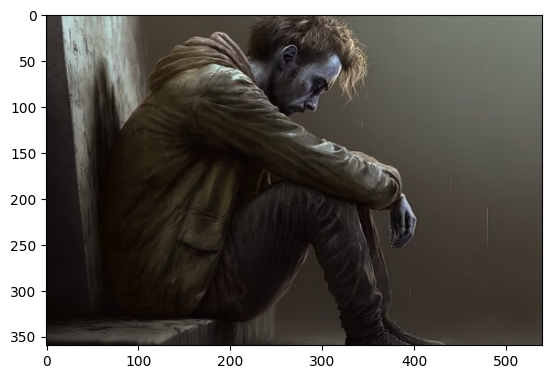

In [170]:
#img = cv2.imread('154006829.jpg')
img = cv2.imread('sad2.jpg')
plt.imshow(img)
plt.show()

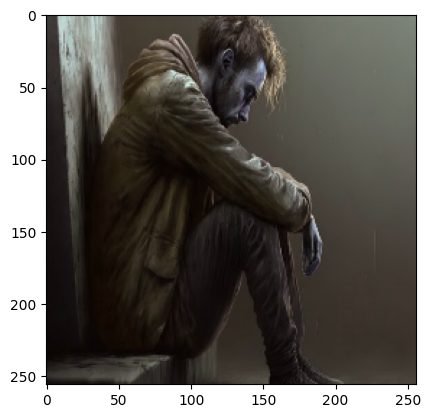

In [171]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [172]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [173]:
yhat

array([[0.99999976]], dtype=float32)

In [174]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [175]:
from tensorflow.keras.models import load_model

In [176]:
model.save(os.path.join('models','imageclassifier.h5'))

In [177]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [178]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 53ms/step


In [179]:
if yhatnew > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
